In [2]:
import numpy as np
import pandas as pd
import csv
from scipy.constants import mu_0, epsilon_0
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets
import discretize
import  os
import json
from PIL import Image
import seaborn as sns
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import ipywidgets as widgets
eps = np.finfo(float).eps

In [3]:
import empymod
from masa_utils import PsuedoLog
from masa_utils import Pelton_res_f
from masa_utils import InducedPolarizationSimulation 
from masa_utils import Optimization 
from masa_utils import empymod_IP_simulation
from masa_utils import TEM_Signal_Process
from masa_utils import enforce_negative_up, enforce_descending_x


Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019). On-Time: 200msec ramp time: 200usec Transmitter Loop: 3.5m Square Loop Receiver Loop: Coincident-type Number of Turn: 5 3.5m rectangular loop has equivalent area for 2.0m circular loop.

In [4]:

rmp_time=200e-6

smp_freq=50e3 #200e3  

In [5]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [6]:
tstrt, tend = 1e-4, 1e-2
logstep = 1/15
WISTEM_SP_sim = TEM_Signal_Process(
    rmp_time=rmp_time, 
    rec_time=tend, 
    smp_freq=smp_freq
)


In [7]:
times_sim = WISTEM_SP_sim.times_rec
times_clc = WISTEM_SP_sim.times_rec
ntimes = len(times_clc)
print(ntimes)
print(times_clc[:3], times_clc[-3:])
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
windows_strt = WISTEM_SP_sim.windows_strt
windows_cen = WISTEM_SP_sim.windows_cen
windows_end = WISTEM_SP_sim.windows_end
print(windows_cen-rmp_time)

500
[2.e-05 4.e-05 6.e-05] [0.00996 0.00998 0.01   ]
[0.0001     0.00011659 0.00013594 0.00015849 0.00018478 0.00021544
 0.00025119 0.00029286 0.00034145 0.00039811 0.00046416 0.00054117
 0.00063096 0.00073564 0.0008577  0.001      0.00116591 0.00135936
 0.00158489 0.00184785 0.00215443 0.00251189 0.00292864 0.00341455
 0.00398107 0.00464159 0.0054117  0.00630957 0.00735642 0.00857696]


In [8]:
nlayer =1

rho0_target = 0.3
eta_target, eta_ref = 0.4, 0.01
eta_sea , eta_base = 0.,0.
c_target = 0.5
thick_target = 10.
tau_target = 100e-3

res_sea = 0.3
res_base = 1.0
tau_sea, tau_base = tau_target, tau_target
c_sea, c_base = c_target, c_target
rho0_refs = np.r_[rho0_target, rho0_target , rho0_target]
# tau_refs = np.r_[0.003,0.03, 0.3]
tau_refs = np.r_[0.01,0.3, 1.0]
c_refs = np.r_[c_target, c_target, c_target]

tx_height = 0.1 #csx
depth = np.r_[0, thick_target]
depth+=tx_height
print(f"depth {depth}")

print(tx_height)

depth [ 0.1 10.1]
0.1


In [9]:
nmodel=3
m_trues = []
m_refs = []
m_true  = np.r_[np.log(rho0_target), eta_target, np.log(tau_target), c_target]
for i in range(nmodel):
    m_trues.append(m_true)
    m_ref = np.r_[np.log(rho0_refs[i]), eta_ref, np.log(tau_refs[i]), c_refs[i]]
    m_refs.append(m_ref)
print(m_refs)   


[array([-1.2039728 ,  0.01      , -4.60517019,  0.5       ]), array([-1.2039728,  0.01     , -1.2039728,  0.5      ]), array([-1.2039728,  0.01     ,  0.       ,  0.5      ])]


In [10]:
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
filt_linrmp = WISTEM_SP_sim.filter_linear_rmp()

Window_mat = WISTEM_SP_sim.get_window_matrix(times_sim)
print(Window_mat.shape)

(30, 500)


In [11]:
recx, recy = 0 , 0
recBdple = [recx, recy, tx_depth ,0,90]
# recx, recy, recw = rec_area(3, tx_side)
# recBdple = [recx, recy, tx_depth ,0,90]

In [12]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_sim = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    # receiver at the center of the transmitter loop
    'rec': recBdple, # [recx, recy, tx_depth ,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
#    'res' : res,
#    'freqtime': times_sim,
    'signal': None, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': 8.*n_turns* tx_surface * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [13]:
sim_obs=empymod_IP_simulation(ip_model='pelton',
    model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
    times=times_sim, smp_freq=smp_freq
    )
sim_obs.deepsea_signle_layer(
    res_sea=res_sea, res_base=res_base,
    eta_sea=eta_sea, eta_base=eta_base,
    tau_sea=tau_sea, tau_base=tau_base, 
    c_sea=c_sea, c_base=c_base
    )


In [14]:
print(sim_obs.m_fix)
print(sim_obs.model_base)

[-1.2039728   0.          0.          0.          0.          0.
 -2.30258509  0.         -2.30258509  0.5         0.          0.5       ]
{'src': [1.75, 1.75, 0, 1.75, 0, 0], 'rec': [0, 0, 0, 0, 90], 'depth': array([ 0.1, 10.1]), 'signal': None, 'msrc': False, 'mrec': True, 'strength': np.float64(0.0006157521600223001), 'srcpts': 3, 'verb': 0, 'xdirect': True}


In [15]:
mvec_obs = m_trues[0]
sim_obs.cut_off = None
dpred_step= sim_obs.dpred(mvec_obs)
sim_obs.cut_off = smp_freq/2.0
print(f"cutoff frequency: {sim_obs.cut_off}")
dpred_LPF = sim_obs.dpred(mvec_obs)
sim_obs.filt_curr = filt_linrmp
dpred_rmp = sim_obs.dpred(mvec_obs)
sim_obs.window_mat=Window_mat
dpred_window = sim_obs.dpred(mvec_obs)

cutoff frequency: 25000.0


In [16]:
PL_decay = PsuedoLog(
    logmin=1e-8,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.5
    )
PL_jac = PsuedoLog(
    logmin=1e-8,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.2
    )

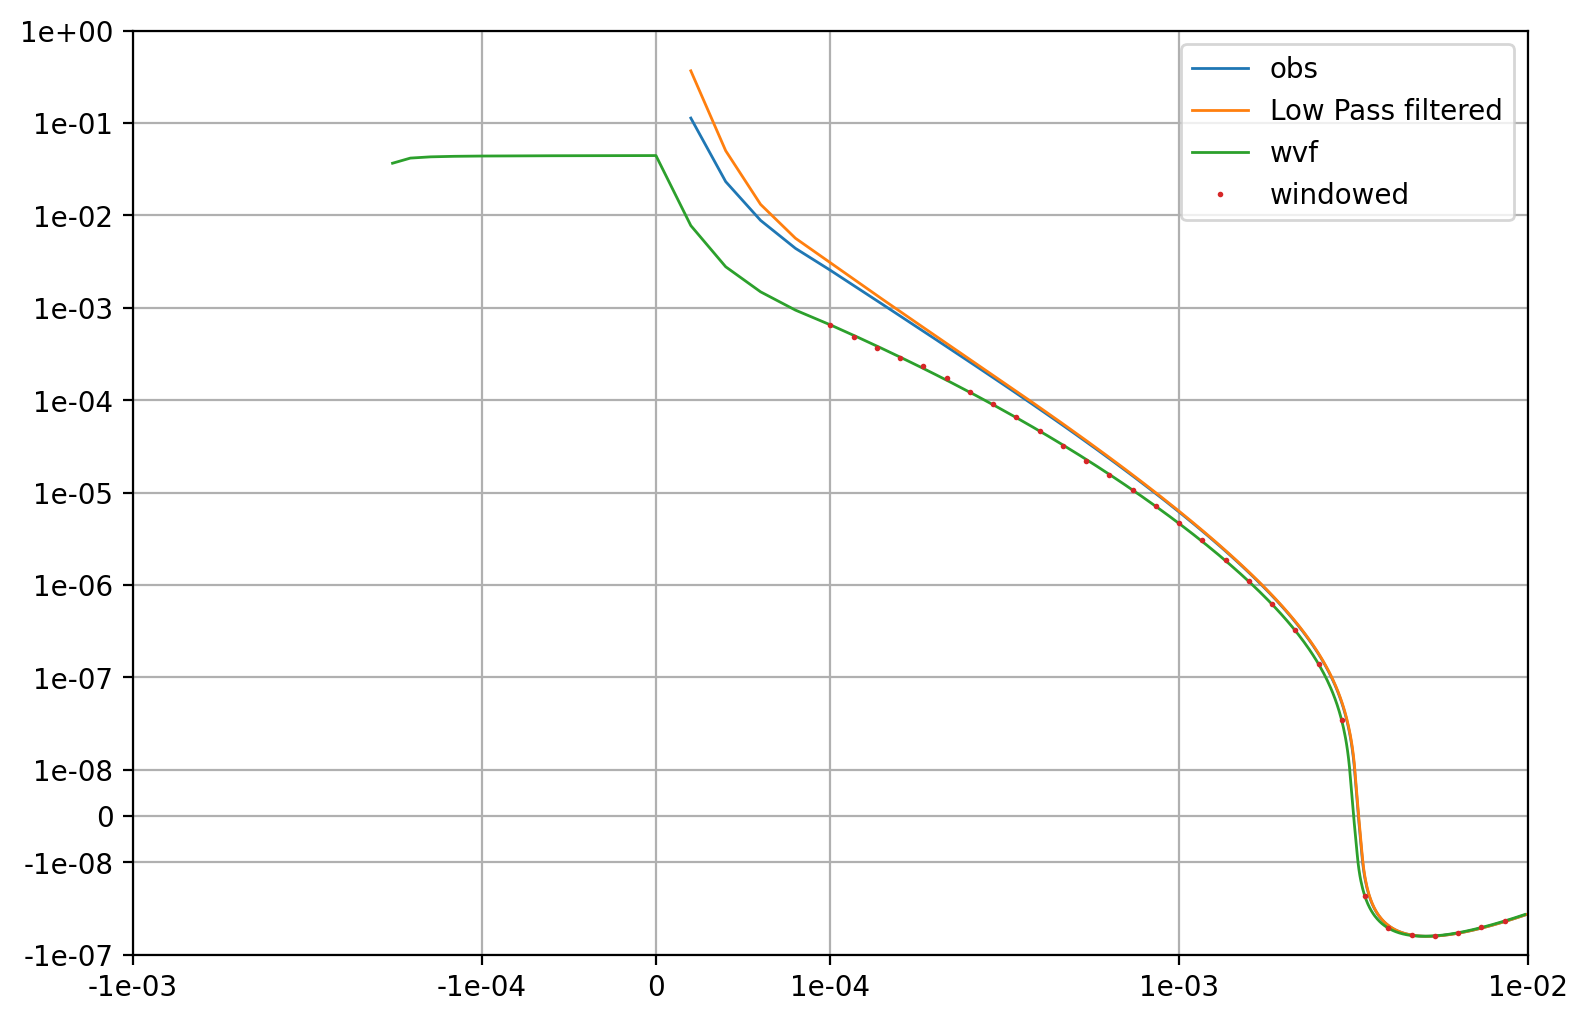

In [17]:

fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax= PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax= PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax= PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax= PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax= PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [18]:
relative_error=0.05
data_noise_floor = 0.1e-7

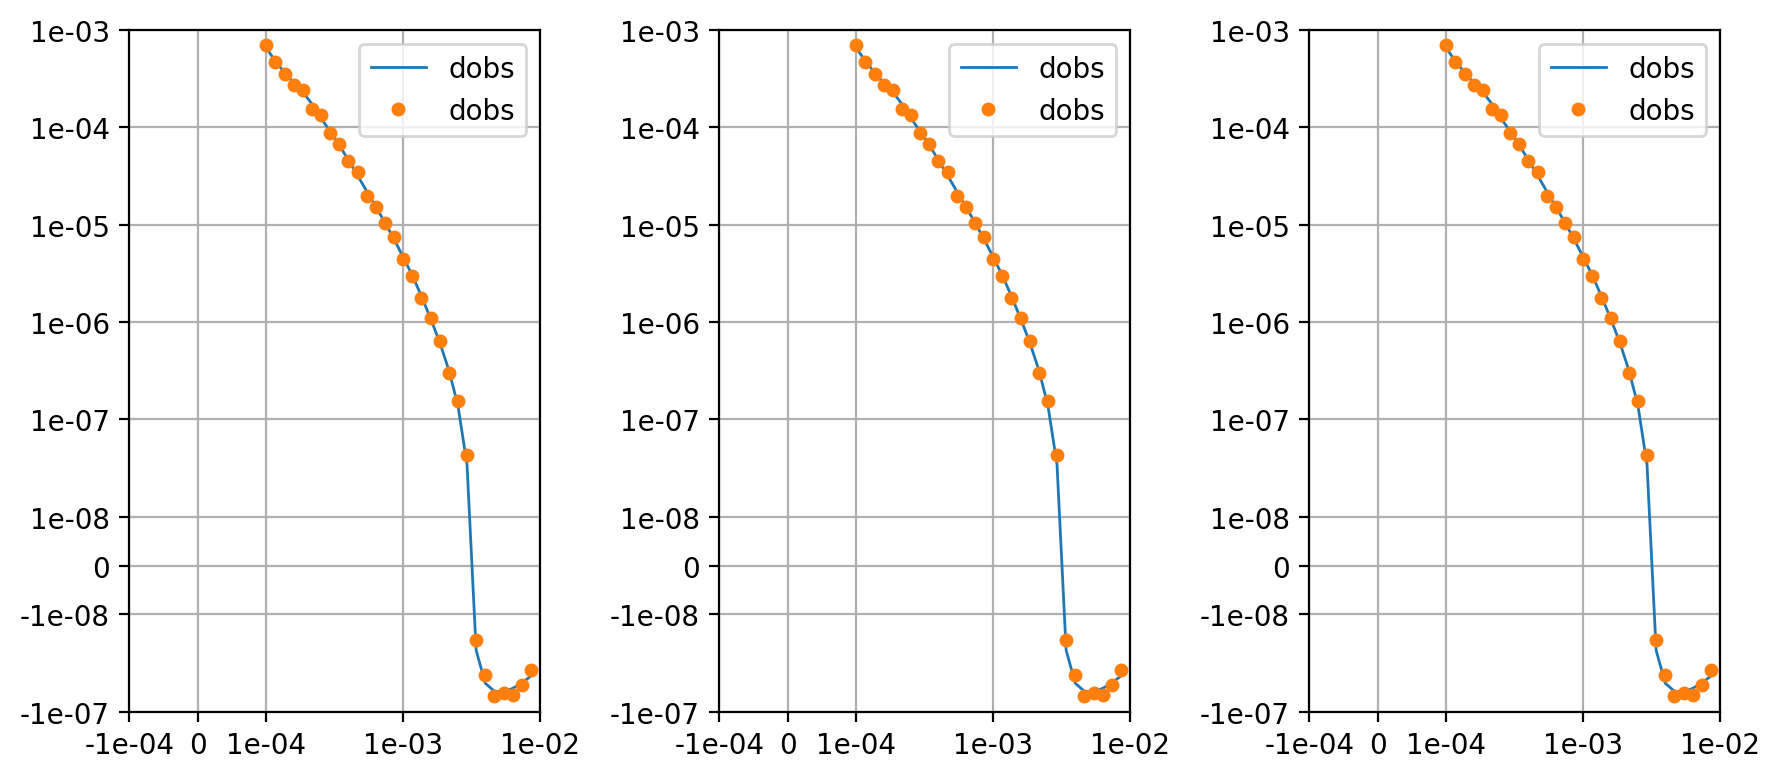

In [19]:
fig, ax= plt.subplots(1,3, figsize=(9,4), dpi=200)
dobs_cmb =[]
ax= ax.flatten()
 # For reproducibility
for i in range(nmodel):
   # np.random.seed(i) # if you wanto have different noise for each model 
    # if you want the same noise for each model
   np.random.seed(1)
   # Calculate noise floor and relative erro at each window
   mvec_obs = m_trues[i]
   dobs_clean=sim_obs.dpred(mvec_obs)
   noise_floor = data_noise_floor
   noise_relative = relative_error * np.abs(dobs_clean)

   # Combine the two sources of noise
   total_noise = np.sqrt(noise_floor**2 + noise_relative**2)

   # Add the combined noise to the clean data
   dobs = dobs_clean +  np.random.randn(len(dobs_clean)) * total_noise

   dobs_cmb.append(dobs)
   ax[i]=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs_clean, 
      label="dobs", color="C0", linestyle="-",ax=ax[i]
   )
   ax[i]=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs, 
      label="dobs", color="C1", marker="o",markersize=4,linestyle="",ax=ax[i]
   )
   ax[i]= PL_decay.pl_axes(ax[i])
   ax[i]= PL_decay.pl_axes_x(ax[i])
#for ax in ax:
   ax[i].grid()
   ax[i].legend()
plt.tight_layout()   

# Invert with Pelton model

In [20]:
niter = 70
stol=1e-6
coolingFactor = 2 # np.sqrt(2) #2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1
Ws_threshold=1e-1

In [21]:
models_rec = []
dpreds = []
error_prgs = []
model_prgs = []
dinit_refs = []
data_prgs =[]
for i in range(nmodel):
    m_ref = m_refs[i]
    dobs = dobs_cmb[i]
    opt_pelton = Optimization(sim=sim_obs, dobs=dobs, alphas=1.0,Ws_threshold=Ws_threshold)
    opt_pelton.get_Wd(ratio=relative_error, plateau=noise_floor)
    Wd=opt_pelton.Wd
    smallness = np.ones(4)
    opt_pelton.get_Ws(smallness=smallness)
    beta0 = opt_pelton.BetaEstimate_byEig(
        mvec=m_ref, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt_pelton.GaussNewton(
    mvec_init=m_ref,niter=niter,beta0=beta0, update_Wsen=True,
    stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
    )
    
    dinit_refs.append(opt_pelton.dpred(m_ref))
    models_rec.append(mpred)
    dpreds.append(opt_pelton.dpred(mpred))
    error_prgs.append(opt_pelton.error_prg)
    model_prgs.append(opt_pelton.mvec_prg)
    data_prgs.append(opt_pelton.data_prg)


2983748.947016051
  1, beta:3.0e+06, step:1.0e+00, g:8.7e+03, phid:3.0e+03, phim:4.5e-06, f:3.0e+03 
  2, beta:3.0e+06, step:1.0e+00, g:1.2e+02, phid:3.0e+03, phim:4.7e-06, f:3.0e+03 
  3, beta:1.5e+06, step:1.0e+00, g:4.4e+03, phid:3.0e+03, phim:1.8e-05, f:3.0e+03 
  4, beta:1.5e+06, step:1.0e+00, g:1.4e+02, phid:3.0e+03, phim:1.9e-05, f:3.0e+03 
  5, beta:7.5e+05, step:1.0e+00, g:4.4e+03, phid:2.8e+03, phim:7.2e-05, f:2.9e+03 
  6, beta:7.5e+05, step:1.0e+00, g:2.8e+02, phid:2.8e+03, phim:7.8e-05, f:2.9e+03 
  7, beta:3.7e+05, step:1.0e+00, g:4.5e+03, phid:2.6e+03, phim:2.9e-04, f:2.7e+03 
  8, beta:3.7e+05, step:1.0e+00, g:5.9e+02, phid:2.6e+03, phim:3.3e-04, f:2.7e+03 
  9, beta:1.9e+05, step:1.0e+00, g:4.8e+03, phid:2.1e+03, phim:1.1e-03, f:2.4e+03 
 10, beta:1.9e+05, step:1.0e+00, g:1.1e+03, phid:2.0e+03, phim:1.4e-03, f:2.3e+03 
 11, beta:9.3e+04, step:1.0e+00, g:5.1e+03, phid:1.3e+03, phim:4.1e-03, f:1.7e+03 
 12, beta:9.3e+04, step:5.0e-01, g:2.3e+03, phid:1.3e+03, phim:4.0e-0

In [22]:

Ws = opt_pelton.Ws
print(np.diag(Ws))

[0.2666269  1.         0.11271304 0.5870571 ]


In [23]:
phid_star=len(windows_cen)
models_rec_phid = []
dpreds_phid = []
phid_star_ratio =1.1
phid_itrs = []
for i in range(nmodel):
    model_prg= np.array(model_prgs[i])
    data_prg = np.array(data_prgs[i])
    error_prg = error_prgs[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        ind = phid_prg == np.min(phid_prg)
        print("No iteration below phid_star, take min phid")
    phid_itr = np.where(ind)[0][0]
    models_rec_phid.append(model_prg[ind][0])
    dpreds_phid.append(data_prg[ind][0])
    phid_itrs.append(phid_itr)


In [24]:
print( "Parameter:     res0,   chg,       tau,     c")

for i in range(nmodel):
    np_mvec_ref = m_refs[i]
    np_mvec_est = models_rec[i]
    m_est_phid = models_rec_phid[i]
    mvec_obs = m_trues[i]
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1]:.3f} & {np.exp(np_mvec_ref[2]):.2e} & {np_mvec_ref[3]:.3f}")
    # print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1]:.3f} & { np.exp(np_mvec_est[2]):.2e} & { np_mvec_est[3]:.3f}")
    print(f"est_phid{i+1}& {np.exp(m_est_phid[0]):.2e} & { m_est_phid[1]:.3f} & { np.exp(m_est_phid[2]):.2e} & { m_est_phid[3]:.3f}")
    print(f"true     & {np.exp(mvec_obs[0]):.2e} & {mvec_obs[1]:.3f} & {np.exp(mvec_obs[2]):.2e} & {mvec_obs[3]:.3f}")

Parameter:     res0,   chg,       tau,     c
ref1     & 3.00e-01 & 0.010 & 1.00e-02 & 0.500
est_phid1& 2.43e-01 & 0.225 & 1.41e-02 & 0.603
true     & 3.00e-01 & 0.400 & 1.00e-01 & 0.500
ref2     & 3.00e-01 & 0.010 & 3.00e-01 & 0.500
est_phid2& 2.61e-01 & 0.297 & 3.49e-02 & 0.523
true     & 3.00e-01 & 0.400 & 1.00e-01 & 0.500
ref3     & 3.00e-01 & 0.010 & 1.00e+00 & 0.500
est_phid3& 2.82e-01 & 0.355 & 6.81e-02 & 0.496
true     & 3.00e-01 & 0.400 & 1.00e-01 & 0.500


In [25]:
S_pelton= []
for i in range(nmodel):
    # jacobian = sim_obs.J(models_rec[i])
    jacobian = sim_obs.J(models_rec_phid[i])
    U, S, V = np.linalg.svd(Wd@jacobian, full_matrices=False)
    s_norm = S/S.max()
    S_pelton.append(s_norm)
print(S_pelton)

[array([1.        , 0.2487376 , 0.07317285, 0.00184313]), array([1.00000000e+00, 3.27127799e-01, 7.00792443e-02, 9.24595404e-04]), array([1.00000000e+00, 3.84858081e-01, 6.08587982e-02, 6.08979013e-04])]


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


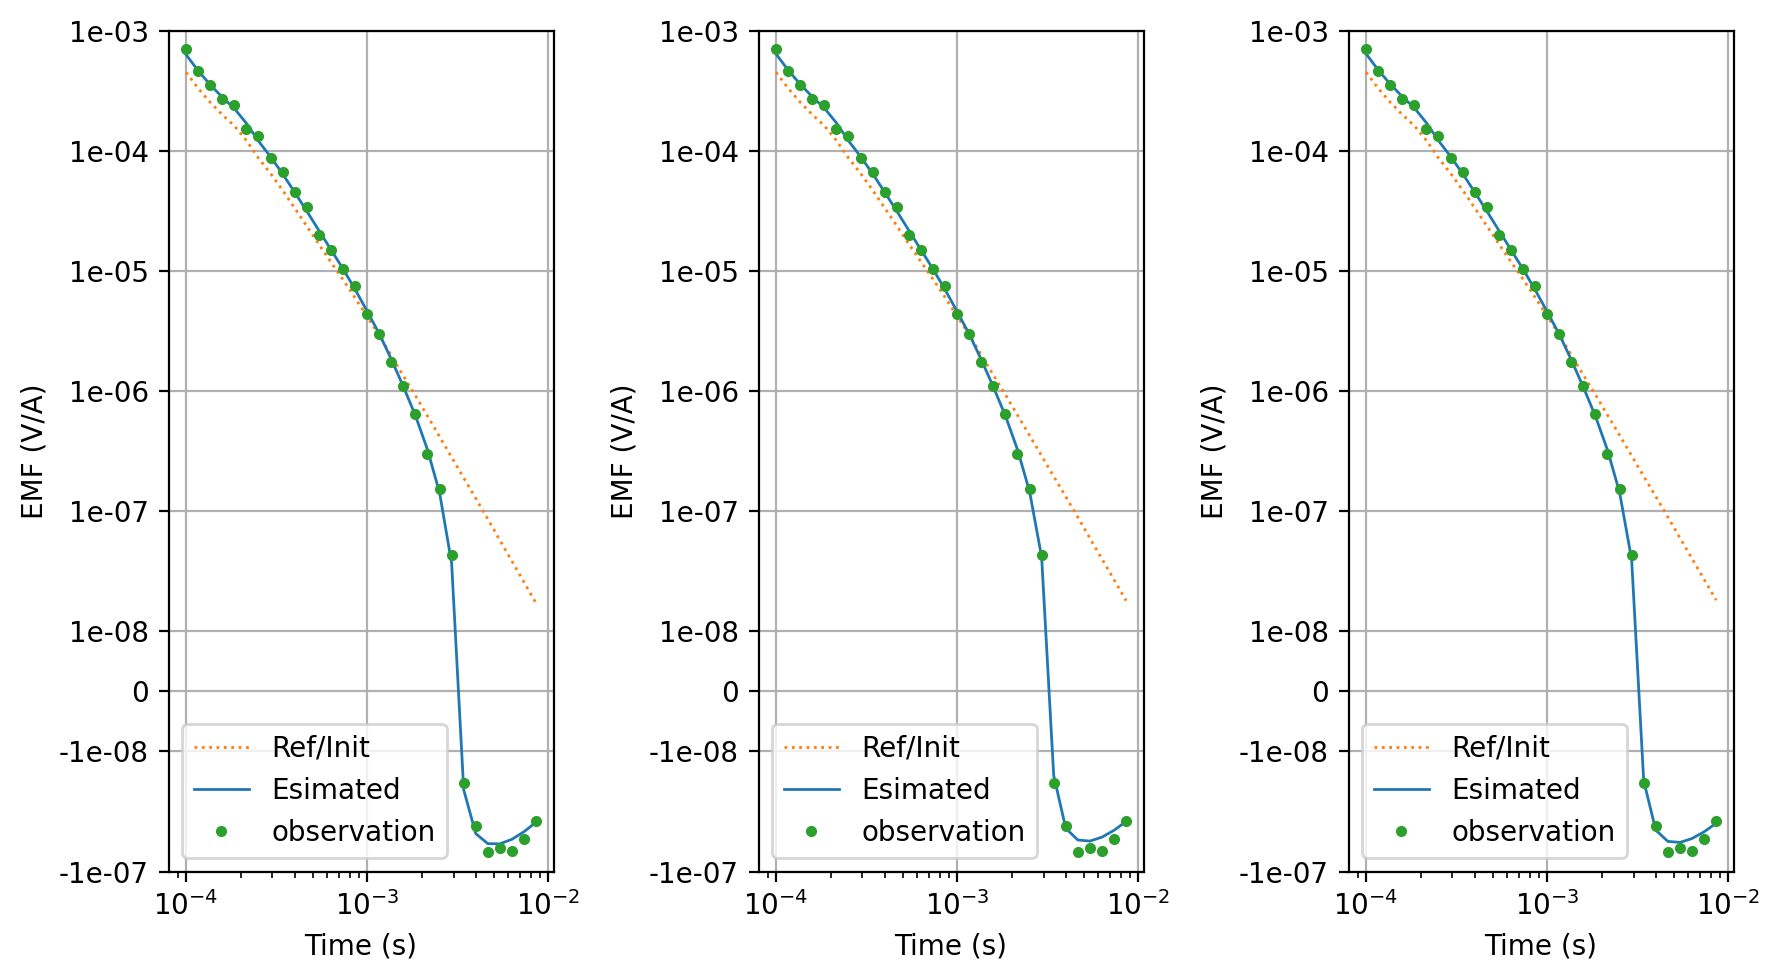

In [26]:
fig, ax= plt.subplots(1,nmodel, figsize=(9,5), dpi=200)
ax= ax.flatten()
for i in range(nmodel):
    dobs= dobs_cmb[i]   
    dinit_ref = dinit_refs[i]

    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dinit_ref, ax=ax[i],
        color=f"C1",linestyle=":", label=f"Ref/Init"
        )

    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dpreds_phid[i], ax=ax[i],
        color=f"C0",linestyle="-", label=f"Esimated"
        )
    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dobs, ax=ax[i], marker="o",markersize=3.0,
        color=f"C2",linestyle="", label="observation"
        )
    ax[i] = PL_decay.pl_axes(ax[i])
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("EMF (V/A)")
plt.tight_layout()

In [27]:

rho0_invs_pel = []
eta_invs_pel = []
tau_invs_pel = []
c_invs_pel = []
ntau_cmb = []
for i in range(nmodel):
    model_pelton = models_rec_phid[i]
    rho0 =(np.exp(model_pelton[0].item()))
    eta = (model_pelton[1].item())
    tau = (np.exp(model_pelton[2].item()))
    c = (model_pelton[3].item())
    rho0_invs_pel.append(np.array(rho0))
    eta_invs_pel.append(np.array(eta))
    tau_invs_pel.append(np.array(tau))
    c_invs_pel.append(np.array(c))


# Get sip of the target

In [28]:
freq = 10.**np.arange(-1,5.1,0.1)
nfreq = len(freq)
IP_model = Pelton_res_f(freq=freq)
sim_sip = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')


In [29]:
# relative_error = 0.05
noise_floor_ratio = 1e-3
niter = 100
stol=1e-6
coolingFactor = 2 
coolingRate = 2
mu=1e-3
beta0_ratio = 1.0

In [30]:
sip_trues =[]
sip_dpreds = []

for i in range(nmodel):
    mvec_obs = m_trues[i]
    sip_trues.append(sim_sip.dpred(m=mvec_obs))
    sip_dpreds.append(sim_sip.dpred(models_rec_phid[i]))
    


In [31]:
def plot_data(iteration, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data_init, ax=ax,
                       color="C1",label="Ref"
                       )
    ax=PL_decay.semiply(windows_cen-rmp_time, dpreds, ax=ax
                        ,color="C0",linestyle="-",
                        label=f"Est" #, iter={iteration}"
                        )
    ax=PL_decay.semiply(windows_cen-rmp_time, dobs, ax=ax, marker="o",markersize=3.0,
                       color="C2",linestyle="", label="Obs"
                       )
    ax = PL_decay.pl_axes(ax)
    # ax.grid()
    # ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(fr""" Data plot
$C_{{err}}$ {relative_error*100:.1f} %, $\epsilon_{{floor}}$ {data_noise_floor:.1e} V/A""")
    return ax

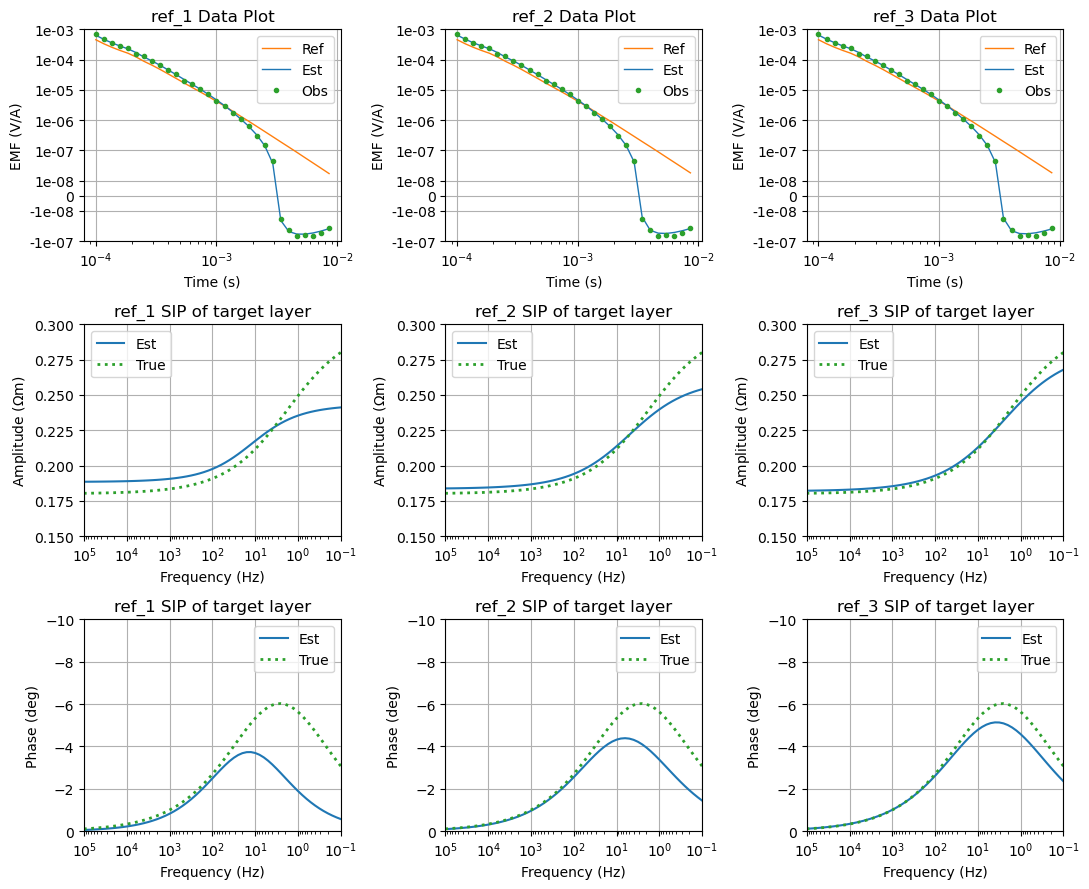

In [32]:
fig, ax = plt.subplots(3, nmodel, figsize=(11,9))
title_heads = ["ref_1", "ref_2", "ref_3"]  
ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nmodel):
    title_head = title_heads[i]
    phid_itr = phid_itrs[i]
    data_init = dinit_refs[i]
    dpreds = dpreds_phid[i]
    dobs= dobs_cmb[i]
    m_ref = m_refs[i]
    m_true = m_trues[i]
    model = models_rec_phid[i]
    ax_range = ax_ranges[i]
    axdata = ax_range[0]
    axdata = plot_data(iteration=phid_itr, ax=axdata)
    axsip = [ax_range[1], ax_range[2]]
    axsip = sim_sip.plot_sip_model(
        model, color="C0", label="Est", linestyle="-",ax=axsip
    )
    axsip = sim_sip.plot_sip_model(
        m_true, color="C2", label="True", linestyle=":", linewidth=2.0,
        ax=axsip
    )
    axsip[1] = enforce_descending_x(axsip[1])
    axsip[0] = enforce_descending_x(axsip[0])
    axsip[1] = enforce_negative_up(axsip[1])
    axsip[0].set_ylim(bottom=0.15, top=0.30)
    axsip[1].set_ylim(top=-10, bottom=0)
    for a in axsip:
        a.set_xlim(left=1e5, right=0.1)

    for a in ax_range:
        a.legend()
        a.grid()

    ax_range[0].set_title(f"{title_head} Data Plot")
    ax_range[1].set_title(f"{title_head} SIP of target layer")
    ax_range[2].set_title(f"{title_head} SIP of target layer")

plt.tight_layout()
# plt.savefig('34_Pelton_data.jpg', dpi=300)

# Plot Inversion result

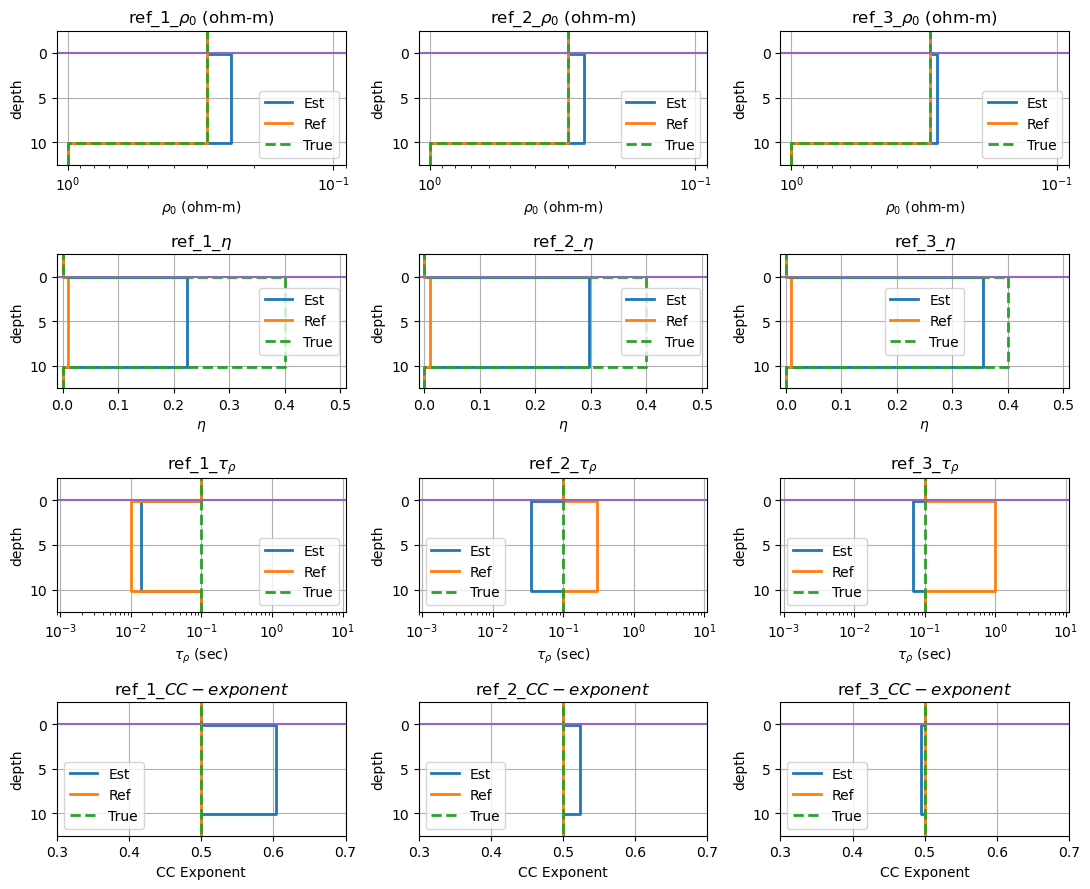

In [33]:
fig, ax = plt.subplots(4, nmodel, figsize=(11,9))

ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0], ax[3,0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1], ax[3,1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2], ax[3,2]])
for i in range(nmodel):
    title_head = title_heads[i]
    m_tem = models_rec_phid[i]
    m_ref = m_refs[i]
    # m_sip = sip_true_inv[i] 
    m_true = m_trues[i]
    axtmp = ax_ranges[i]
    axtmp = sim_obs.plot_IP_par(mvec=m_tem, 
        label="Est", color=f"C0", linestyle="-", 
        ax=axtmp, linewidth=2.0)
    # rho0,eta = sim.ip_model.get_rho_eta(models_rec_phid[i])
    axtmp = sim_obs.plot_IP_par(mvec=m_ref, 
            label="Ref", color=f"C1", linestyle="-",
            ax=axtmp, linewidth=2.0)

    # label = fr"est_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"

    axtmp = sim_obs.plot_IP_par(mvec=m_true, 
            label="True", color=f"C2", linestyle="--",
            ax=axtmp, linewidth=2.0)
    # rho0,eta = sim.ip_model.get_rho_eta(sip_true_inv[i])
    # label = fr"tru_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"

    axtmp[0].set_xlim([1.1,0.09])
    axtmp[1].set_xlim([-0.01,0.51])
    axtmp[2].set_xlim([0.9e-3,1.1e+1])
    axtmp[3].set_xlim([0.3,0.7])

    for j , a in enumerate(axtmp):  # Iterate over rows
        a.grid()
        a.legend()
        a.axhline(empymod_model_sim["src"][4], color=f"C4", linestyle="-", label="Src+Rec")
        a.set_ylim([12.5, -2.5])
        a.set_ylabel('depth')
        if j== 0 or j==2:
            a.set_xscale("log")
        else:
            a.set_xscale("linear")
    axtmp[0].set_title(fr"{title_head}_$\rho_0$ (ohm-m)")
    axtmp[1].set_title(fr"{title_head}_$\eta$")
    axtmp[2].set_title(fr"{title_head}_$\tau_\rho$")
    axtmp[3].set_title(fr"{title_head}_$CC-exponent$")

plt.tight_layout()
# plt.savefig('34_Pelton_recovered.jpg', dpi=300)

In [34]:
def plot_each_data(data, ax=None, **kwargs):
    default_kwargs = {
        "linestyle": "-",
        "color": "C0",
        "linewidth": 1.0,
        "marker": None,
        "markersize": 1,
    }
    default_kwargs.update(kwargs)
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data, ax=ax,
                       **default_kwargs
                       )
    ax = PL_decay.pl_axes(ax)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
    return ax

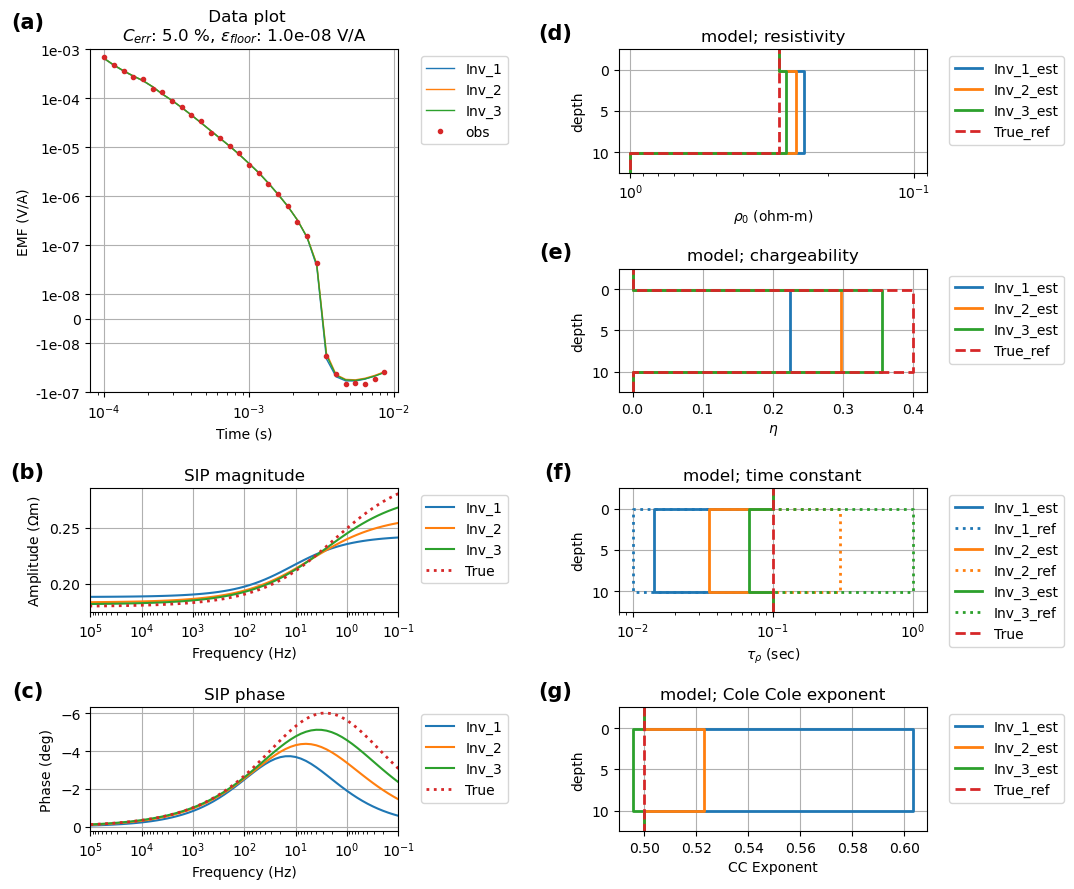

In [ ]:

title_heads = ["Inv_1", "Inv_2", "Inv_3"] #  ["ref_0", "ref_1", "ref_2"] 

fig = plt.figure(figsize=(11, 9))
gs = gridspec.GridSpec(4, 2)  
ax = [None] * 7

# Subplots
ax[0] = fig.add_subplot(gs[:2, 0])
ax[1] = fig.add_subplot(gs[2, 0])
ax[2] = fig.add_subplot(gs[3, 0])
ax[3] = fig.add_subplot(gs[0, 1])
ax[4] = fig.add_subplot(gs[1, 1])
ax[5] = fig.add_subplot(gs[2, 1])
ax[6] = fig.add_subplot(gs[3, 1])

axdata = ax[0]
axsip = [ax[1], ax[2]]
ax_dum = [
    fig.add_subplot(gs[0, 1], frameon=False),
    fig.add_subplot(gs[1, 1], frameon=False),
    fig.add_subplot(gs[2, 1], frameon=False),
    fig.add_subplot(gs[3, 1], frameon=False),
]

for a in ax_dum:
    a.set_visible(False)

axmodel_rmc = [ax[3], ax[4], ax_dum[2]   , ax[6]]
axmodel_tau  = [ax_dum[0], ax_dum[1], ax[5], ax_dum[3]   ]
data_init = dinit_refs[0]

# axdata = plot_each_data(data=data_init,
#             label=f"ref/init",color=f"k", 
#             ax=axdata)
# m_ref = m_refs[0]
# axmodel= sim_obs.plot_IP_par(mvec=m_ref, 
#     label="ref/init", color="k", linestyle="-", 
#     ax=axmodel, linewidth=2.0)

for i in range(nmodel):
    title_head = title_heads[i]
    dpreds = dpreds_phid[i]
    m_tem = models_rec_phid[i]
    m_true = m_trues[i]
    m_ref = m_refs[i]
    # ax_range = ax_ranges[i]
    axdata = plot_each_data(data=dpreds,
             label=f"{title_head}",color=f"C{i}", 
             ax=axdata)
    axsip = sim_sip.plot_sip_model(
        m_tem, color=f"C{i}", label=f"{title_head}", linestyle="-",ax=axsip
    )

    axmodel_rmc= sim_obs.plot_IP_par(mvec=m_tem, 
        label=f"{title_head}_est", color=f"C{i}", linestyle="-", 
        ax=axmodel_rmc, linewidth=2.0)
    axmodel_tau= sim_obs.plot_IP_par(mvec=m_tem, 
        label=f"{title_head}_est", color=f"C{i}", linestyle="-", 
        ax=axmodel_tau, linewidth=2.0)
    axmodel_tau= sim_obs.plot_IP_par(mvec=m_ref, 
        label=f"{title_head}_ref", color=f"C{i}", linestyle=":", 
        ax=axmodel_tau, linewidth=2.0)


axmodel_rmc = sim_obs.plot_IP_par(mvec=m_true,
        label="True_ref", color=f"C{nmodel}", linestyle="--",
        ax=axmodel_rmc, linewidth=2.0)
axmodel_tau = sim_obs.plot_IP_par(mvec=m_true, 
        label="True", color=f"C{nmodel}", linestyle="--",
        ax=axmodel_tau, linewidth=2.0)




axmodel = [axmodel_rmc[0], axmodel_rmc[1], axmodel_tau[2], axmodel_rmc[3]]

dobs= dobs_cmb[0]
# ax_range = ax_ranges[i]
axdata = plot_each_data(data=dobs,
            label=f"obs",color=f"C{nmodel}", 
            linestyle="", marker="o", markersize=3.0,
            ax=axdata)


axsip = sim_sip.plot_sip_model(
    m_true, color=f"C{nmodel}", label="True", linestyle=":", linewidth=2.0,
    ax=axsip
)
axsip[1] = enforce_descending_x(axsip[1])
axsip[0] = enforce_descending_x(axsip[0])
axsip[1] = enforce_negative_up(axsip[1])

# axsip[0].set_ylim(bottom=0.15, top=0.30)
# axsip[1].set_ylim(top=-8, bottom=0)
for a in axsip:
    a.set_xlim(left=1e5, right=0.1)


axdata.set_title(fr""" Data plot
$C_{{err}}$: {relative_error*100:.1f} %, $\epsilon_{{floor}}$: {data_noise_floor:.1e} V/A""")
ax[1].set_title(f"SIP magnitude")
ax[2].set_title(f"SIP phase")

axmodel[0].set_xlim([1.1,0.09])
# axmodel[1].set_xlim([-0.01,0.51])
# axmodel[2].set_xlim([0.9e-3,1.1])
# axmodel[3].set_xlim([0.35,1.0])
axmodel[0].set_title("model; resistivity")
axmodel[1].set_title("model; chargeability")
axmodel[2].set_title("model; time constant")
axmodel[3].set_title("model; Cole Cole exponent")

for j , a in enumerate(axmodel):  # Iterate over rows
    # a.axhline(empymod_model_sim["src"][nmodel+1], color=f"C4", linestyle="-", label="Src+Rec")
    a.set_ylim([12.5, -2.5])
    a.set_ylabel('depth')
    if j== 0 or j==2:
        a.set_xscale("log")
    else:
        a.set_xscale("linear")

for a in ax:
    a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # a.legend()
    a.grid()

# for a in axsip:
#     a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

for label, axis in zip(panel_labels, ax):
    axis.text(
        -0.15, 1.05, label,
        transform=axis.transAxes,
        fontsize=15, fontweight='bold',
        va='bottom', ha='right'
    )

fig_dum, ax_dum = None, None  # Close the dummy figure

plt.tight_layout()
plt.savefig('34_Pelton.jpg', dpi=300)
plt.savefig('34_Pelton.pdf',  bbox_inches="tight")

In [36]:
def sci_latex(v, prec=2):
    s = f"{v:.{prec}e}"          # e.g. '3.00e-03'
    mant, exp = s.split('e')     # '3.00', '-03'
    exp = int(exp)               # remove leading zeros
    return rf"{mant}\times 10^{{{exp}}}"


In [39]:
rho0_print =[]
eta_print =[]
tau_print =[]
c_print =[]

rho0_print.append(rho0_target)
eta_print.append(eta_target)
tau_print.append(tau_target)
c_print.append(c_target)

for i in range(nmodel):
    rho0_print.append(rho0_refs[i])
    rho0_print.append(rho0_invs_pel[i])
    eta_print.append(eta_ref)
    eta_print.append(eta_invs_pel[i])
    tau_print.append(tau_refs[i])
    tau_print.append(tau_invs_pel[i])
    c_print.append(c_refs[i])
    c_print.append(c_invs_pel[i])



In [ ]:
titles = []
for i in range(nmodel):
    titles.append("reference")
    titles.append("inverted")

print(" & " + " & ".join(s for s in titles) +  r"\\")

print("\hline")
print(r"$\rho_0$ & "
      +" & ".join(f"{v: .2f}" for v in rho0_print
      )
      + r"\\"
)

print(r"$\eta$ & "
      +" & ".join(f"{v:.2f}" for v in eta_print
      )
       + r"\\"
)
print(r"$\tau_\rho$ & $ "
      + "$ & $ ".join(sci_latex(v, 1) for v in tau_print
      )
      + r"$ \\"
)

print(" C & "
      +" &".join(f"{v:.2f}" for v in c_print
      )
      + r"\\"
)


 & reference & inverted & reference & inverted & reference & inverted\\
\hline
$\rho_0$ &  0.30 &  0.30 &  0.24 &  0.30 &  0.26 &  0.30 &  0.28\\
$\eta$ & 0.40 & 0.01 & 0.22 & 0.01 & 0.30 & 0.01 & 0.36\\
$\tau_\rho$ & $ 1.0\times 10^{-1}$ & $ 1.0\times 10^{-2}$ & $ 1.4\times 10^{-2}$ & $ 3.0\times 10^{-1}$ & $ 3.5\times 10^{-2}$ & $ 1.0\times 10^{0}$ & $ 6.8\times 10^{-2}$ \\
 C & 0.50 &0.50 &0.60 &0.50 &0.52 &0.50 &0.50\\
